In [1]:
from __future__ import print_function
import itertools, struct

valid_cells = [
    (i, j)
    for i in range(8)
    for j in range(8)
]
valid_cells_set = set(valid_cells)

# This includes some impossible origins, but it doesn't matter because we filter down later.
squid_origins = [
    (squid_top_left, squid_direction)
    for squid_top_left in valid_cells
    for squid_direction in (False, True)
]

def squid_spot(squid_desc, offset):
    (x, y), direction = squid_desc
    return (x + offset, y) if direction else (x, y + offset)

def _find_all_configs(masks, inverse_weights, taken_so_far, remaining_lengths, denom):
    if len(remaining_lengths) == 0:
        masks.append(taken_so_far)
        inverse_weights.append(denom)
        return

    squid_len = remaining_lengths[0]
    good_descs = []
    for squid_desc in squid_origins:
        for offset in range(squid_len):
            new_spot = squid_spot(squid_desc, offset)
            if new_spot in taken_so_far or new_spot not in valid_cells_set:
                break
        else:
            good_descs.append(squid_desc)

    for squid_desc in good_descs:
        t = taken_so_far.copy()
        for offset in range(squid_len):
            t.add(squid_spot(squid_desc, offset))
        _find_all_configs(masks, inverse_weights, t, remaining_lengths[1:], denom * len(good_descs))

    return find_all_configs

def find_all_configs(lengths):
    masks = []
    inverse_weights = []
    _find_all_configs(masks, inverse_weights, set(), lengths, 1)
    return masks, inverse_weights

masks,    inverse_weights    = find_all_configs([2, 3, 4])
# These are NOT the correct weights, but compute them for fun.
#masks432, inverse_weights432 = find_all_configs([4, 3, 2])
print("Length:", len(masks))
print("Probs:", set(inverse_weights))

total_prob = 0
for w in inverse_weights:
    total_prob += 1.0 / w
print("Total prob:", total_prob)

Length: 604584
Probs: set([659456, 630784, 581504, 520128, 633360, 510496, 675360, 623616, 500864, 642096, 591360, 545664, 598080, 631904, 643104, 710976, 578144, 627984, 601216, 680064, 682864, 621712, 611072, 635040, 535920, 687792, 685440, 607936, 611520, 618016, 655200, 645120, 522368, 690368, 506688, 667856, 620928, 604800, 695520, 662480, 564480, 647920, 532224, 700672, 638848, 703248, 594720, 652848, 558208, 608048, 542080, 640640, 628544, 657888, 677824, 693056, 616448, 669760, 516432, 614880, 606816, 713440, 526176, 551936, 574560, 597184, 650496, 568176, 624960, 618240, 587552, 721280, 705600, 555408, 577920, 561792, 672672, 601328, 660352, 568288, 652288, 574896, 558656, 665280, 649152, 626080, 565152, 549024, 571648, 594384, 670208, 539392, 604128, 588112, 584640, 637952, 591136, 613872, 529760])
Total prob: 1.0


In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
probabs    = np.array([1.0 / w for w in inverse_weights])
#probabs432 = np.array([1.0 / w for w in inverse_weights432])

In [19]:
print("Maximum bias:", max(probabs) / min(probabs))

Maximum bias: 1.4400715563506261


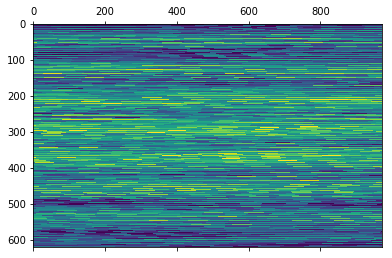

In [4]:
plt.matshow(probabs.reshape((622, 972)))
#plt.matshow(probabs432.reshape((622, 972)))

In [5]:
# We now build a matrix.
presence_matrix = np.array([[cell in mask for cell in valid_cells] for mask in masks], dtype=np.int8)
probab_weighted_presence_matrix = presence_matrix * probabs.reshape((-1, 1))

In [16]:
cell_to_index = {cell: i for i, cell in enumerate(valid_cells)}

def compute_probabilities(hits, misses):
    # This is a simple Bayes update.
    #   P(cell contains squid | observation) =
    #       P(cell contains squid AND observation) / P(observation)
    # Note that P(cell contains squid AND observation) is just P(cell contains squid)
    # if the observation is compatible
    # Start with a mask saying every possible board is admissible.
    mask = np.array([True] * presence_matrix.shape[0], np.bool)
    # Filter out all the boards that are incompatible with a hit we've seen so far.
    for hit in hits:
        mask &= presence_matrix[:, cell_to_index[hit]] == 1
    # Filter out all the boards that are incompatible with a miss we've seen so far.
    for miss in misses:
        mask &= presence_matrix[:, cell_to_index[miss]] == 0
    # Compute the total probability of every board layout compatible with our observation.
    # This is simply P(observation).
    observation_probability = probabs[mask].sum()
    # Marginalize the distribution, and renormalize by the 
    return probab_weighted_presence_matrix[mask].sum(axis=0) / observation_probability

def make_greedy_move(hits, misses):
    weights = compute_probabilities(hits, misses)
    for cell in hits + misses:
        weights[cell_to_index[cell]] = -1
    return valid_cells[np.argmax(weights)]

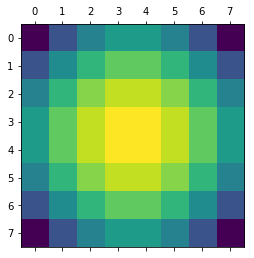

In [7]:
plt.matshow(probab_weighted_presence_matrix.sum(axis=0).reshape(8, 8))

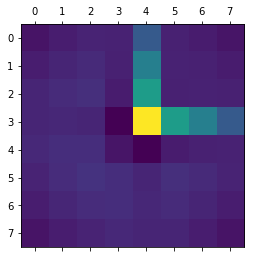

In [12]:
plt.matshow(compute_probabilities([(3, 4)], [(3, 3), (4, 4)]).reshape(8, 8))

In [18]:
make_greedy_move([(3, 4)], [(3, 3), (4, 4)])

(2, 4)

In [ ]:
def make_board():
    

In [ ]:
def play_random_game():
    